# Sampling Measure Zero Polyhedra

We start with a HPolyhedron defined by
$$
    Ax \leq b
$$
$$
    Cx = d
$$

## Defining the original polyhedron P

In [ ]:
from large_gcs.geometry.polyhedron import Polyhedron
import numpy as np
import matplotlib.pyplot as plt

P_verts = np.array([[1,1],[3,1]])
P = Polyhedron.from_vertices(P_verts)
P._vertices = P_verts
P.plot()

In [ ]:
P.set.A()

In [ ]:
P.set.b()

In [ ]:
P.has_equality_constraints()

In [ ]:
A,b,C,d = P.get_separated_inequality_equality_constraints()

In [ ]:
A

In [ ]:
b

In [ ]:
C

In [ ]:
d

## Finding the null space of a matrix

In [ ]:
import numpy as np
from scipy.linalg import null_space

# Define your matrix X
X = np.array([
    [1, 2, 3, 5],
    [4, 5, 6, 2],
    [7, 8, 9, 1]
])

# Find the basis for the kernel of X
kernel_basis = null_space(X)

print("Basis for the kernel of X:")
print(kernel_basis)
X @ kernel_basis


### Find the basis of the null space of C

In [ ]:
V = null_space(C)
V

In [ ]:
V.shape

## Find $x_0$ such that $Cx_0 = d$

In [ ]:
# Compute the pseudo-inverse of C
C_pinv = np.linalg.pinv(C)

# Use the pseudo-inverse to find x_0
x_0 = np.dot(C_pinv, d)
x_0

In [ ]:
# Alternatively, solve the system Cx = d in a least squares sense
x_0 = np.linalg.lstsq(C, d, rcond=None)[0]
x_0

In [ ]:
Q = Polyhedron(A = A@V, b = b - A @ x_0)

In [ ]:
q_samples = Q.get_samples(20)
q_samples.shape

In [ ]:
V.shape

In [ ]:
p_samples = q_samples @ V.T + x_0
p_samples

In [ ]:
P.plot()
plt.scatter(p_samples[:,0], p_samples[:,1], c = 'r', marker='x')

Now that we've built in this functionality into the `Polyhedron` class, can simply call `get_samples`

In [ ]:
samples = P.get_samples(20)
len(samples)
samples

# Check that it works for contact sets with equality constraints

In [ ]:
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.graph_generators.contact_graph_generator import ContactGraphGeneratorParams


graph_file = ContactGraphGeneratorParams.graph_file_path_from_name("cg_simple_2")
cg = ContactGraph.load_from_file(graph_file)
cg.plot()


In [ ]:
for v in cg.vertex_names:
    cg.plot_samples_in_set(v, 20)

# Edge Case
Sets that collapse to a single point because of a bunch of inequalities resulting in an equality constraint that is not of the form $$ax \leq b, ax \geq b$$ and so cannot be easily detected.

In [1]:
import numpy as np
import logging
from large_gcs.geometry.polyhedron import Polyhedron
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph_generators.contact_graph_generator import ContactGraphGeneratorParams
from large_gcs.graph.graph import Vertex


logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 4990.25it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 6553.60it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 45.79it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (151)
100%|██████████| 151/151 [00:02<00:00, 64.89it/s]
DEBUG:large_gcs.geometry.polyhedron:
 A.shape: (50, 14), b.shape: (50,), C.shape: (8, 14), d.shape: (8,)
DEBUG:large_gcs.geometry.polyhedron:ranks: A: 14, C: 8
DEBUG:large_gcs.geometry.polyhedron:
 A.shape: (60, 16), b.shape: (60,), C.shape: (12, 16), d.shape: (12,)
DEBUG:large_gcs.geometry.polyhedron:ranks: A: 16, C: 12


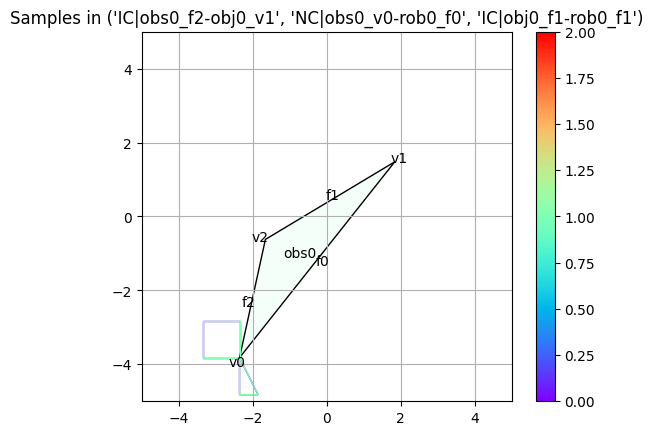

In [2]:


graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_maze_b1")
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
)
contact_pair_mode_ids = (
        "IC|obs0_f2-obj0_v1",
        "NC|obs0_v0-rob0_f0",
        "IC|obj0_f1-rob0_f1",
    )
v_name = str(contact_pair_mode_ids)
contact_set = cg._create_contact_set_from_contact_pair_mode_ids(
    contact_pair_mode_ids
)
vertex = Vertex(
    contact_set,
    cg._create_single_vertex_costs(contact_set),
    constraints=cg._create_single_vertex_constraints(contact_set)
)
cg.add_vertex(vertex, v_name)
chebyshev_center = contact_set.set.ChebyshevCenter()
cg.plot_samples_in_set(v_name, np.array([chebyshev_center]))


There is only one point that satisfies these constraints, and when the tolerance is set to 0, even the Chebyshev Center is not considered to be in the set due to small numerical errors.

In [8]:
contact_set.set.PointInSet(chebyshev_center, tol=0)

False

The behavior I chose to implement in this situation is to just return the chebyshev center as the only sample in the event that the sampling fails due to the chebyshev center not being in the set. This seems fine to me since there will only be one feasible point anyways so it does not make sense to return multiple samples.

In [6]:
len(contact_set.get_samples(10))

1

In [7]:
P = contact_set._polyhedron
E = P._null_space_polyhedron.set.MaximumVolumeInscribedEllipsoid()

RuntimeError: Solver Mosek failed to solve the maximum inscribed ellipse problem; it terminated with SolutionResult SolverSpecificError). Make sure that your polyhedron is bounded and has an interior.